https://github.com/linhaoqi027/SEG-GRAD-CAM

https://github.com/kiraving/SegGradCAM

https://github.com/chungtd89/unet/blob/master/model.py

https://github.com/chungtd89/grad-cam-heat-map-membrane-segmentation-u-net/blob/master/src/Membrane_Segmentation_Heatmap_GradCAM_stepperepoch100.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import sys
ROOT_DIR="/content/drive/MyDrive/Mtech_project/Nazrin_F4K_segmentation_Model1/Unet_segmentation"
sys.path.append(ROOT_DIR)

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard
import matplotlib.pyplot as plt
#from data import load_data, tf_dataset
from data import load_data
from model_py import build_model

#from grad_cam1 import GradCam1,superimpose
from grad_cam2 import GradCam,GradCam1,superimpose,GradCamPlusPlus, ScoreCam, build_guided_model, GuidedBackPropagation, superimpose

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model=build_model()

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 96, 96, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 96, 96, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 96, 96, 16)   0           ['batch_normalization[0][0]']

In [ ]:
from data import load_data #fish_08

In [ ]:
if __name__ == "__main__":                                
     ## Dataset
     path = "/content/drive/MyDrive/Mtech_project/dataset/F4k_08"
     (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)

In [ ]:
len(train_x)

176

In [ ]:
from keras.preprocessing import image
import numpy as np
import cv2
from tensorflow.keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
def read_and_preprocess_img_naz(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    #x = preprocess_input(x)
    return x

In [ ]:
def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))
def superimpose1(original_img_path, cam, emphasize=False):
    
    img_bgr = cv2.imread(original_img_path)

    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, 0.5, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .5
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

In [ ]:
for i in test_x:
  print(i)
  

/content/drive/MyDrive/Mtech_project/dataset/F4k_08/images/fish_000026930001_02782.png
/content/drive/MyDrive/Mtech_project/dataset/F4k_08/images/fish_000026380001_02576.png
/content/drive/MyDrive/Mtech_project/dataset/F4k_08/images/fish_000037699596_04304.png
/content/drive/MyDrive/Mtech_project/dataset/F4k_08/images/fish_000026930001_02784.png
/content/drive/MyDrive/Mtech_project/dataset/F4k_08/images/fish_003772196012_13071.png
/content/drive/MyDrive/Mtech_project/dataset/F4k_08/images/fish_000026920001_02770.png
/content/drive/MyDrive/Mtech_project/dataset/F4k_08/images/fish_000006019596_03826.png
/content/drive/MyDrive/Mtech_project/dataset/F4k_08/images/fish_000027230001_02858.png
/content/drive/MyDrive/Mtech_project/dataset/F4k_08/images/fish_003865466237_25528.png
/content/drive/MyDrive/Mtech_project/dataset/F4k_08/images/fish_003460000108_03276.png
/content/drive/MyDrive/Mtech_project/dataset/F4k_08/images/fish_003888846299_26670.png
/content/drive/MyDrive/Mtech_project/datase

In [ ]:
def GradCam2(model, img_array, layer_name):
    #cls = np.argmax(model.predict(img_array))
    
    """GradCAM method for visualizing input saliency."""
    y_c =  model.output[:, 0] #index = 0 since there is only 1 output from the network
    conv_output = model.get_layer(layer_name).output
    grads = tf.gradients(y_c, conv_output)[0]
    # grads = normalize(grads)

    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img_array])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))

    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    if (np.max(cam)) == 0:
      return cam
      
    else:  
      cam /= np.max(cam)  # scale 0 to 1.0  

    return cam

In [ ]:
layer_name = "conv2d_13"
#img_path="/content/drive/MyDrive/Mtech_project/dataset/F4k_08/fish_08/fish_000026380001_02576.png"
#img_path="/content/drive/MyDrive/Mtech_project/dataset/F4k_08/images/fish_000006019596_03828.png"
img_path ="/content/fish_000004380001_00174.png"
img = image.load_img(img_path, target_size=(96, 96), color_mode="rgb") #adjust according to model.summary input layer
img_array = read_and_preprocess_img_naz(img)

grad_cam=GradCam1(model,img_array,layer_name)
grad_cam_superimposed = superimpose(img_path, grad_cam)
grad_cam_emphasized = superimpose(img_path, grad_cam, emphasize=True)

'''grad_cam_plus_plus=GradCamPlusPlus(model,img_array,layer_name)
grad_cam_plus_plus_superimposed = superimpose1(img_path, grad_cam_plus_plus)
grad_cam_plus_plus_emphasized = superimpose(img_path, grad_cam_plus_plus, emphasize=True)'''

0.026947232


'grad_cam_plus_plus=GradCamPlusPlus(model,img_array,layer_name)\ngrad_cam_plus_plus_superimposed = superimpose1(img_path, grad_cam_plus_plus)\ngrad_cam_plus_plus_emphasized = superimpose(img_path, grad_cam_plus_plus, emphasize=True)'

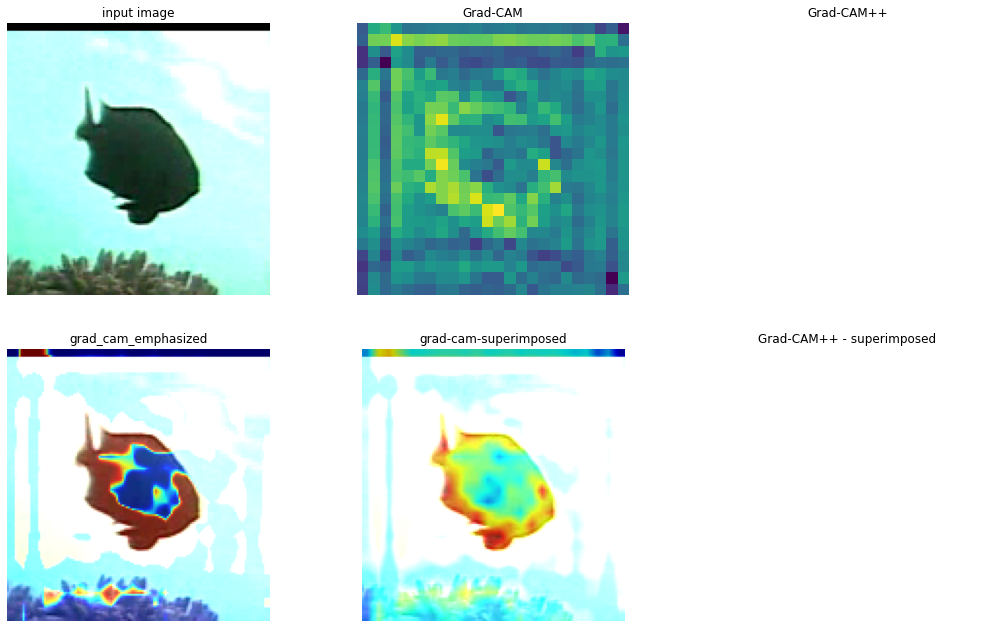

In [ ]:
img = image.load_img(img_path)
fig, ax = plt.subplots(nrows=2,ncols=3, figsize=(18, 11))
ax[0,0].imshow(img)
ax[0,0].set_title("input image")
ax[0,1].imshow(grad_cam)
ax[0,1].set_title("Grad-CAM")
#ax[0,2].imshow(grad_cam_plus_plus)
ax[0,2].set_title("Grad-CAM++")
#ax[0,4].imshow(faster_score_cam)
#ax[0,4].set_title("Faster-Score-CAM")
ax[1,0].imshow(grad_cam_emphasized)
ax[1,0].set_title("grad_cam_emphasized")
ax[1,1].imshow(grad_cam_superimposed)
ax[1,1].set_title("grad-cam-superimposed")
#ax[1,2].imshow(grad_cam_plus_plus_superimposed)
ax[1,2].set_title("Grad-CAM++ - superimposed")
#ax[0,4].imshow(faster_score_cam_superimposed)
#ax[0,4].set_title("Faster-Score-CAM")
for i in range(2):
    for j in range(3):
        ax[i,j].axis('off')
#plt.savefig('/content/drive/MyDrive/Mtech_project/Nazrin_F4K_segmentation_Model1/Unet_segmentation/results/feb8_3_gradcam.pdf',dpi=600,bbox_inches='tight')
#plt.savefig('/content/drive/MyDrive/Mtech_project/Nazrin_F4K_segmentation_Model1/Unet_segmentation/results/feb8_3_gradcam.tif',dpi=600,bbox_inches='tight')
plt.show()

0.00071112247


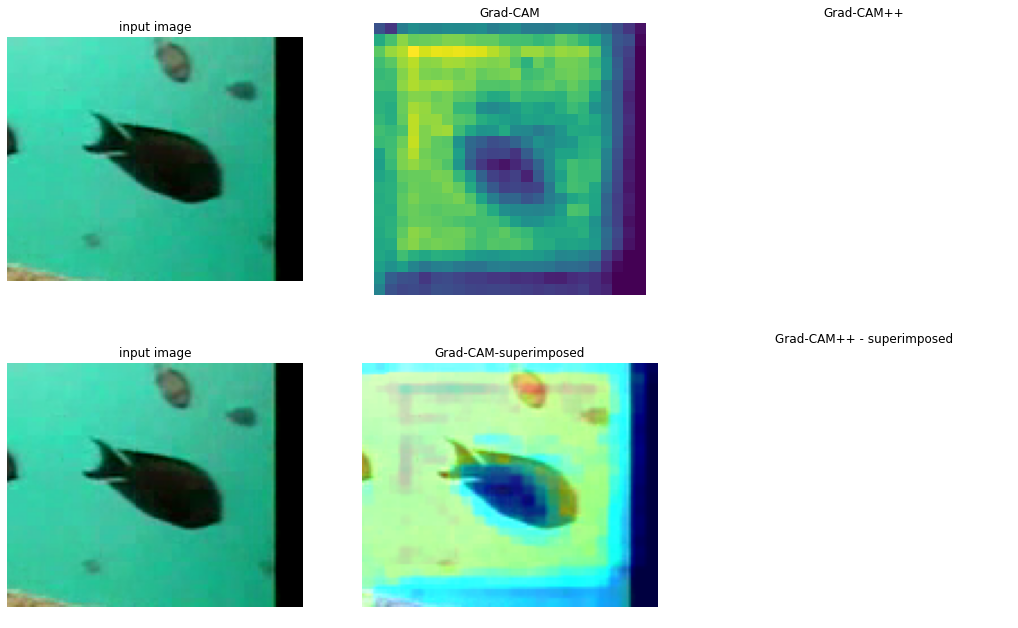

In [ ]:
layer_name = "up_sampling2d_2"
'''img_path="/content/drive/MyDrive/Mtech_project/dataset/F4k_08/fish_08/fish_000026380001_02576.png"
img = image.load_img(img_path, target_size=(96,96), color_mode="rgb") #adjust according to model.summary input layer
img_array = read_and_preprocess_img_naz(img)'''

grad_cam=GradCam1(model,img_array,layer_name)
grad_cam_superimposed = superimpose1(img_path, grad_cam)
grad_cam_emphasized = superimpose(img_path, grad_cam, emphasize=True)

img = image.load_img(img_path, target_size=(48,48), color_mode="rgb") #adjust according to model.summary input layer
img_array = read_and_preprocess_img_naz(img)

'''grad_cam_plus_plus=GradCamPlusPlus(model,img_array,layer_name)
grad_cam_plus_plus_superimposed = superimpose1(img_path, grad_cam_plus_plus)
grad_cam_plus_plus_emphasized = superimpose(img_path, grad_cam_plus_plus, emphasize=True)'''

img = image.load_img(img_path)
fig, ax = plt.subplots(nrows=2,ncols=3, figsize=(18, 11))
ax[0,0].imshow(img)
ax[0,0].set_title("input image")
ax[0,1].imshow(grad_cam)
ax[0,1].set_title("Grad-CAM")
#ax[0,2].imshow(grad_cam_plus_plus)
ax[0,2].set_title("Grad-CAM++")
#ax[0,4].imshow(faster_score_cam)
#ax[0,4].set_title("Faster-Score-CAM")
ax[1,0].imshow(img)
ax[1,0].set_title("input image")
ax[1,1].imshow(grad_cam_superimposed)
ax[1,1].set_title("Grad-CAM-superimposed")
#ax[1,2].imshow(grad_cam_plus_plus_superimposed)
ax[1,2].set_title("Grad-CAM++ - superimposed")
#ax[0,4].imshow(faster_score_cam_superimposed)
#ax[0,4].set_title("Faster-Score-CAM")
for i in range(2):
    for j in range(3):
        ax[i,j].axis('off')
plt.savefig('/content/drive/MyDrive/Mtech_project/Nazrin_F4K_segmentation_Model1/Unet_segmentation/results/2_cams_jan31/d2_4.pdf',dpi=600,bbox_inches='tight')
plt.show()

In [ ]:
layer_name = "up_sampling2d_1"
'''img_path="/content/drive/MyDrive/Mtech_project/dataset/F4k_08/fish_08/fish_000026380001_02576.png"
img = image.load_img(img_path, target_size=(96, 96), color_mode="rgb") #adjust according to model.summary input layer
img_array = read_and_preprocess_img_naz(img)'''

grad_cam=GradCam1(model,img_array,layer_name)
grad_cam_superimposed = superimpose1(img_path, grad_cam)
grad_cam_emphasized = superimpose(img_path, grad_cam, emphasize=True)

'''grad_cam_plus_plus=GradCamPlusPlus(model,img_array,layer_name)
grad_cam_plus_plus_superimposed = superimpose1(img_path, grad_cam_plus_plus)
grad_cam_plus_plus_emphasized = superimpose(img_path, grad_cam_plus_plus, emphasize=True)
'''
img = image.load_img(img_path)
fig, ax = plt.subplots(nrows=2,ncols=3, figsize=(18, 11))
ax[0,0].imshow(img)
ax[0,0].set_title("input image")
ax[0,1].imshow(grad_cam)
ax[0,1].set_title("Grad-CAM")
#ax[0,2].imshow(grad_cam_plus_plus)
ax[0,2].set_title("Grad-CAM++")
#ax[0,4].imshow(faster_score_cam)
#ax[0,4].set_title("Faster-Score-CAM")
ax[1,0].imshow(img)
ax[1,0].set_title("input image")
ax[1,1].imshow(grad_cam_superimposed)
ax[1,1].set_title("Grad-CAM-superimposed")
#ax[1,2].imshow(grad_cam_plus_plus_superimposed)
ax[1,2].set_title("Grad-CAM++ - superimposed")
#ax[0,4].imshow(faster_score_cam_superimposed)
#ax[0,4].set_title("Faster-Score-CAM")
for i in range(2):
    for j in range(3):
        ax[i,j].axis('off')
plt.savefig('/content/drive/MyDrive/Mtech_project/Nazrin_F4K_segmentation_Model1/Unet_segmentation/results/2_cams_jan31/d1_4.pdf',dpi=600,bbox_inches='tight')
plt.show()

In [ ]:
layer_name = "activation_3"
img_path="/content/drive/MyDrive/Mtech_project/dataset/F4k_08/fish_08/fish_000007200001_00910.png"
img = image.load_img(img_path, target_size=(96, 96), color_mode="rgb") #adjust according to model.summary input layer
img_array = read_and_preprocess_img_naz(img)

grad_cam=GradCam1(model,img_array,layer_name)
grad_cam_superimposed = superimpose1(img_path, grad_cam)
grad_cam_emphasized = superimpose(img_path, grad_cam, emphasize=True)

'''grad_cam_plus_plus=GradCamPlusPlus(model,img_array,layer_name)
grad_cam_plus_plus_superimposed = superimpose1(img_path, grad_cam_plus_plus)
grad_cam_plus_plus_emphasized = superimpose(img_path, grad_cam_plus_plus, emphasize=True)'''

img = image.load_img(img_path)
fig, ax = plt.subplots(nrows=2,ncols=3, figsize=(18, 11))
ax[0,0].imshow(img)
ax[0,0].set_title("input image")
ax[0,1].imshow(grad_cam)
ax[0,1].set_title("Grad-CAM")
#ax[0,2].imshow(grad_cam_plus_plus)
ax[0,2].set_title("Grad-CAM++")
#ax[0,4].imshow(faster_score_cam)
#ax[0,4].set_title("Faster-Score-CAM")
ax[1,0].imshow(img)
ax[1,0].set_title("input image")
ax[1,1].imshow(grad_cam_superimposed)
ax[1,1].set_title("Grad-CAM-superimposed")
#ax[1,2].imshow(grad_cam_plus_plus_superimposed)
ax[1,2].set_title("Grad-CAM++ - superimposed")
#ax[0,4].imshow(faster_score_cam_superimposed)
#ax[0,4].set_title("Faster-Score-CAM")
for i in range(2):
    for j in range(3):
        ax[i,j].axis('off')
plt.savefig('/content/drive/MyDrive/Mtech_project/Nazrin_F4K_segmentation_Model1/Unet_segmentation/results/2_cams_jan31/d_2.pdf',dpi=600,bbox_inches='tight')
plt.show()